In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import compute_snr
from import_data import convert_units, ImportQNMParameters, ImportDetector


In [12]:
horizons_coeffs = {
    1.5: {
        2: [-0.42378303, 2.22119101, - 2.34699946, - 2.22674388],
        3: [-0.30219477, 1.38081955, - 0.4938548, - 3.95842648],
        '(2,2,1) II': [-0.66852311,  4.05036508, -6.80452328,  1.26800471],
        '(3,3,0)': [-0.72984323,  4.60837898, -8.3414624,   2.31768849],
        '(4,4,0)': [-0.58874309,  3.88021218, -7.19144783,  1.32087045],
        '(2,1,0)': [-2.21026510e-03, -1.31642774e+00,  7.05973356e+00, -1.10706091e+01],
    },
    10: {
#         2: [-0.11210798, 0.22803465, 3.71644785, -7.29147623],
#         3: [-0.70892573, 4.50109537, -8.15164046, 1.62887952],
        '(2,2,1) II': [-0.86209342, 5.76135278, -11.65082754, 4.88450789],
        '(3,3,0)': [-0.95259347, 6.1709775, -12.13801787, 5.37319762],
        '(4,4,0)': [-1.13283604, 7.85887465, -16.92973514, 9.46422891],
    }
}

masses_range = {
    1.5: {
#         2: [3e1, 5e3],
#         3: [8e1, 4e3],
        '(2,2,1) II': [4e1, 4e3],
        '(3,3,0)': [6.5e1, 4e3],
        '(4,4,0)': [1.5e2, 5e3],
        '(2,1,0)': [1.5e2, 1.5e3],
    },
    10: {
#         2: [6e1, 3.5e3],
#         3: [2e2, 3e3],
        '(2,2,1) II': [1.5e2, 2.5e3],
        '(3,3,0)': [7e1, 2.5e3],
        '(4,4,0)': [1e2, 3e3],
    }
}


In [18]:
from scipy import integrate
def luminosity_distance(redshift):
    """
    Compute luminosity distance as function of the redshift

    Parameters
    ----------
        redshift: scalar
            Cosmological redshift value

    Returns
    -------
        scalar: Returns luminosity distance relative to given redshift
    """

    # cosmological constants
    # values from https://arxiv.org/pdf/1807.06209.pdf
    h = 0.6796
    H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
    clight = 2.99792458e8  # speed of lightm s**-1
    Dist_H = clight / H_0  # Huble distance

    Omega_M = 0.315
    Omega_Λ = 1 - Omega_M
    Omega_K = 0.0

    def Ez(z): return 1 / np.sqrt(Omega_M * (1 + z)
                                  ** 3 + Omega_K * (1 + z)**2 + Omega_Λ)
    Dist_C = Dist_H * integrate.quad(Ez, 0, redshift)[0]
    Dist_L = (1 + redshift) * Dist_C

    return Dist_L

In [19]:
# Volume horizon
#     # cosmological constants
#     # values from https://arxiv.org/pdf/1807.06209.pdf
#     h = 0.6796
#     H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
#     clight = 2.99792458e8  # speed of lightm s**-1
#     Dist_H = clight / H_0  # Huble distance

#     Omega_M = 0.315
#     Omega_Λ = 1 - Omega_M
#     Omega_K = 0.0

for m1 in [45, 100]:
    M_total = m1*(1 + 1/1.5)
    final_mass = 0.955234916738*M_total
    
    horizon = np.poly1d(horizons_coeffs[1.5][2])
    redshift = 10**horizon(np.log10(final_mass))
    print('final mass: ', final_mass, ', redshift: ', redshift, 'D_L: ', luminosity_distance(redshift))

final mass:  71.64261875535 , redshift:  0.02280112554854221 D_L:  102.31962911519851
final mass:  159.20581945633333 , redshift:  0.0708714690967674 D_L:  329.1174688431695


In [4]:
N_masses = 100
detector = 'LIGO'

antenna_plus = {
    'LIGO': np.sqrt(1 / 5 / 4 / np.pi),
    'CE':   np.sqrt(1 / 5 / 4 / np.pi),
    'ET':   np.sqrt(1 / 5 / 4 / np.pi) * 3 / 2,
    'LISA': np.sqrt(1 / 4 / np.pi),
}
antenna_cross = antenna_plus
mode_0 = '(2,2,0)'

df = pd.DataFrame()
for mass_ratio, coeffs in horizons_coeffs.items():
    
    noise = ImportDetector(detector)
    qnm_pars = ImportQNMParameters(mass_ratio)
    
    for mode, coeff in coeffs.items():
        horizon = np.poly1d(coeff)
        masses = np.logspace(np.log10(masses_range[mass_ratio][mode][0]), np.log10(
            masses_range[mass_ratio][mode][1]), N_masses, endpoint=True)
        redshifts = []
        snrs = []
        snrs_ringdown = []
        for final_mass in masses:
            redshift = 10**horizon(np.log10(final_mass))
            redshifts.append(redshift)
            time_unit, strain_unit = convert_units(
                final_mass, redshift, qnm_pars.bh_pars['remnant_mass'])
            
            # Compute QNM frequency and damping time according to the source
            freq, tau = {}, {}
            for (_mode, omega) in qnm_pars.omegas.items():
                freq[_mode] = omega['omega_r'] / 2 / np.pi / time_unit
                tau[_mode] = time_unit / omega['omega_i']
                
            # Create qnm parameters dictionary
            qnm_parameters = {}
            qnm_parameters[mode_0] = {
                'freq_array': noise.noise['freq'],
                'A_lmn': qnm_pars.amplitudes[mode_0],
                'phi_lmn': qnm_pars.phases[mode_0],
                'f_lmn': freq[mode_0],
                'tau_lmn': tau[mode_0],
            }
            qnm_parameters[mode] = {
                'freq_array': noise.noise['freq'],
                'A_lmn': qnm_pars.amplitudes[mode],
                'phi_lmn': qnm_pars.phases[mode],
                'f_lmn': freq[mode],
                'tau_lmn': tau[mode],
            }
            snrs.append(compute_snr.compute_SRN(strain_unit, antenna_plus[detector],
                    antenna_cross[detector], qnm_parameters[mode], noise.noise))
            snrs_ringdown.append(compute_snr.compute_SRN_2modes(strain_unit, antenna_plus[detector],
                    antenna_cross[detector], qnm_parameters[mode_0], qnm_parameters[mode], noise.noise))
        print(mode)
        
        df_aux = pd.DataFrame(
            {
                'mass': masses,
                'redshift': redshifts,
                'snr': snrs,
                'snr_ringdown': snrs_ringdown,
                'mass_ratio': [mass_ratio]*len(masses),
                'mode': [mode]*len(masses)
                
            }
        )
        df = pd.concat([df, df_aux])

(2,2,1) II
(3,3,0)
(4,4,0)
(2,1,0)
(2,2,1) II
(3,3,0)
(4,4,0)


No handles with labels found to put in legend.


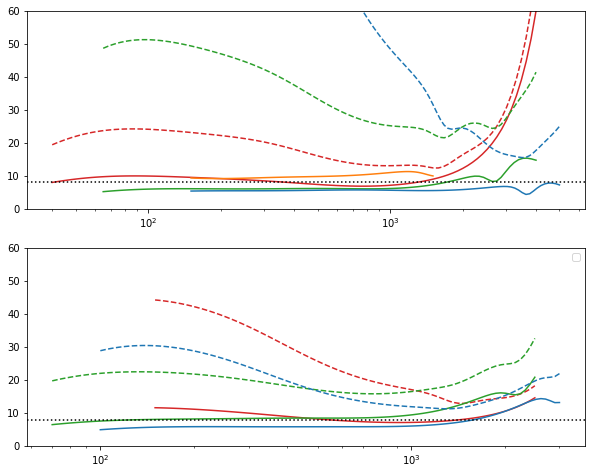

In [5]:
fig, ax = plt.subplots(2, figsize=[10,8])
i = 0
colors = {
    '(2,2,1) II': 'tab:red',
    '(3,3,0)': 'tab:green',
    '(4,4,0)': 'tab:blue',
    '(2,1,0)': 'tab:orange',
}
for q in [1.5, 10]:
    for mode in ('(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)'):
        df_plot = df[(df.mass_ratio == q)&(df['mode'] == mode)]
        df_plot = df_plot.sort_values(by=['mass'])
        ax[i].plot(df_plot.mass, df_plot.snr, color = colors[mode])
        ax[i].plot(df_plot.mass, df_plot.snr_ringdown, color = colors[mode], ls = '--')
    ax[i].set_xscale('log')
    ax[i].set_ylim(0, 60)
    ax[i].axhline(8, color='k', ls = ':')
    i += 1
plt.xscale('log')
plt.legend()

In [6]:
min(df[df.mass<1e3].snr)

4.939445558225283

In [20]:
from ast import literal_eval as make_tuple
df_ray = pd.read_csv('../data/two_modes_horizons_LIGO.dat', sep='\t')
df_ray['modes'] = df_ray.apply(lambda row: make_tuple(row.modes)[1][1]+make_tuple(row.modes)[1][3]+make_tuple(row.modes)[1][5], axis=1)
df_ray

,masses,redshifts,modes,detector,mass_ratio
0,10.000000,0.000089,221,LIGO,1.5
1,10.233718,0.000137,221,LIGO,1.5
2,10.472898,0.000147,221,LIGO,1.5
3,10.717669,0.000154,221,LIGO,1.5
4,10.968160,0.000161,221,LIGO,1.5
...,...,...,...,...,...
1623,1611.973357,0.000133,210,LIGO,10.0
1624,1649.648074,0.000124,210,LIGO,10.0
1625,1688.203317,0.000116,210,LIGO,10.0
1626,1727.659665,0.000105,210,LIGO,10.0


In [24]:
N_masses = 100
detector = 'LIGO'

antenna_plus = {
    'LIGO': np.sqrt(1 / 5 / 4 / np.pi),
    'CE':   np.sqrt(1 / 5 / 4 / np.pi),
    'ET':   np.sqrt(1 / 5 / 4 / np.pi) * 3 / 2,
    'LISA': np.sqrt(1 / 4 / np.pi),
}
antenna_cross = antenna_plus
mode_0 = '(2,2,0)'

df_r = pd.DataFrame()
for mass_ratio in [1.5, 10]:
    noise = ImportDetector(detector)
    qnm_pars = ImportQNMParameters(mass_ratio)
    for mode in set(df_ray.modes.values):
        df_mode = df_ray[(df_ray.modes==mode)&(df_ray.mass_ratio==mass_ratio)]
        masses = df_mode.masses.values
        mode = f'({mode[0]},{mode[1]},{mode[2]})'
        if mode == '(2,2,1)':
            mode = '(2,2,1) II'
        redshifts = []
        snrs = []
        snrs_ringdown = []
        for final_mass in masses:
            redshift = df_mode[(df_mode.masses==final_mass)].redshifts.values[0]
            redshifts.append(redshift)
            time_unit, strain_unit = convert_units(
                final_mass, redshift, qnm_pars.bh_pars['remnant_mass'])
            
            # Compute QNM frequency and damping time according to the source
            freq, tau = {}, {}
            for (_mode, omega) in qnm_pars.omegas.items():
                freq[_mode] = omega['omega_r'] / 2 / np.pi / time_unit
                tau[_mode] = time_unit / omega['omega_i']
                
            # Create qnm parameters dictionary
            qnm_parameters = {}
            qnm_parameters[mode_0] = {
                'freq_array': noise.noise['freq'],
                'A_lmn': qnm_pars.amplitudes[mode_0],
                'phi_lmn': qnm_pars.phases[mode_0],
                'f_lmn': freq[mode_0],
                'tau_lmn': tau[mode_0],
            }

            qnm_parameters[mode] = {
                'freq_array': noise.noise['freq'],
                'A_lmn': qnm_pars.amplitudes[mode],
                'phi_lmn': qnm_pars.phases[mode],
                'f_lmn': freq[mode],
                'tau_lmn': tau[mode],
            }
            snrs.append(compute_snr.compute_SRN(strain_unit, antenna_plus[detector],
                    antenna_cross[detector], qnm_parameters[mode], noise.noise))
            snrs_ringdown.append(compute_snr.compute_SRN_2modes(strain_unit, antenna_plus[detector],
                    antenna_cross[detector], qnm_parameters[mode_0], qnm_parameters[mode], noise.noise))

        df_aux = pd.DataFrame(
            {
                'mass': masses,
                'redshift': redshifts,
                'snr': snrs,
                'snr_ringdown': snrs_ringdown,
                'mass_ratio': [mass_ratio]*len(masses),
                'mode': [mode]*len(masses)
                
            }
        )
        df_r = pd.concat([df_r, df_aux])

In [25]:
df_r

,mass,redshift,snr,snr_ringdown,mass_ratio,mode
0,25.196359,0.000089,84.007957,1034.191600,1.5,"(3,3,0)"
1,25.785244,0.000093,84.434665,1033.499059,1.5,"(3,3,0)"
2,26.387891,0.000098,84.845976,1032.449917,1.5,"(3,3,0)"
3,27.004624,0.000103,85.242377,1031.037219,1.5,"(3,3,0)"
4,27.635770,0.000108,85.623170,1029.253237,1.5,"(3,3,0)"
...,...,...,...,...,...,...
230,2872.063118,0.000321,419.074410,530.819320,10.0,"(2,2,1) II"
231,2939.188399,0.000225,590.326008,751.788295,10.0,"(2,2,1) II"
232,3007.882518,0.000161,812.217204,1040.514321,10.0,"(2,2,1) II"
233,3078.182143,0.000118,1091.552100,1407.228552,10.0,"(2,2,1) II"


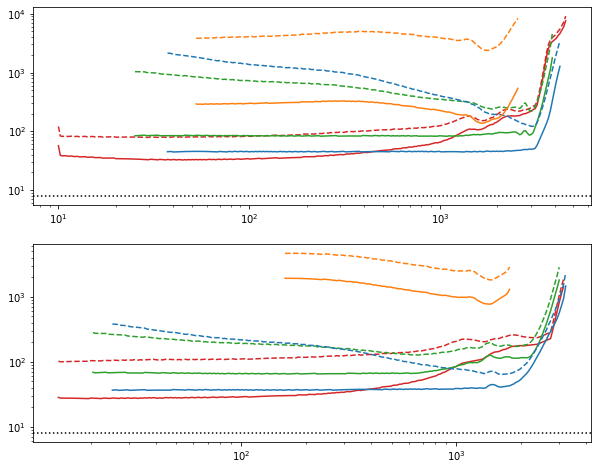

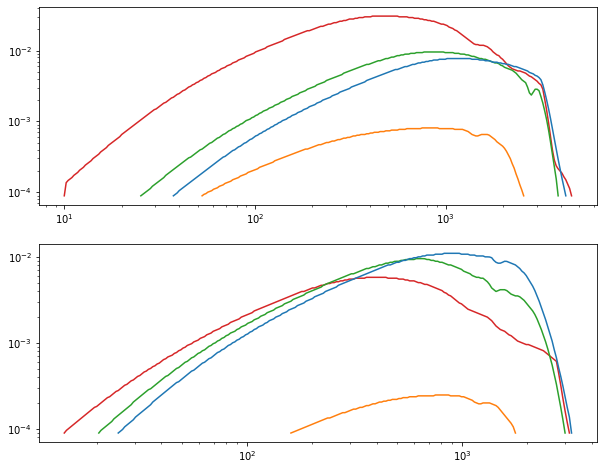

In [26]:
fig, ax = plt.subplots(2, figsize=[10,8])
fig, ax1 = plt.subplots(2, figsize=[10,8])
i = 0
colors = {
    '(2,2,1) II': 'tab:red',
    '(3,3,0)': 'tab:green',
    '(4,4,0)': 'tab:blue',
    '(2,1,0)': 'tab:orange',
}
for q in [1.5, 10]:
    for mode in colors.keys():
        df_plot = df_r[(df_r.mass_ratio == q)&(df_r['mode'] == mode)]
        df_plot = df_plot.sort_values(by=['mass'])
        ax[i].plot(df_plot.mass, df_plot.snr, color = colors[mode])
        ax[i].plot(df_plot.mass, df_plot.snr_ringdown, color = colors[mode], ls = '--')
        ax1[i].loglog(df_plot.mass, df_plot.redshift, color = colors[mode])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
#     ax[i].set_ylim(0, 60)
    ax[i].axhline(8, color='k', ls = ':')
    i += 1
plt.xscale('log')